In [1]:
%load_ext autoreload
%autoreload 2

%pylab inline

from functools import partial
from typing import Callable, List
import warnings

import pandas as pd
from scipy.stats import (multivariate_normal as mnorm,
                         truncnorm as sp_truncnorm,
                         norm as sp_norm,
                         chi2)
import seaborn as sns

from var_selection import gibbs, bayes_factor, variable_selection


pd.set_option('display.max_rows', 10)
sns.set(style='ticks', context='talk')

Populating the interactive namespace from numpy and matplotlib


# Gibbs Sampler

## Test Gibbs Sampler

In [2]:
M = 2
mu = np.random.rand(M) * 100

while True:
    try:
        cov = np.random.rand(M, M)
        cov = (cov + cov.T)/2
        np.linalg.cholesky(cov)
        break
    except np.linalg.LinAlgError:
        pass
print(mu)
print(cov)

[ 53.98233899  69.69061412]
[[ 0.77128333  0.60450188]
 [ 0.60450188  0.50616992]]


x    53.986615
y    69.690966
dtype: float64
          x         y
x  0.749862  0.588120
y  0.588120  0.493174


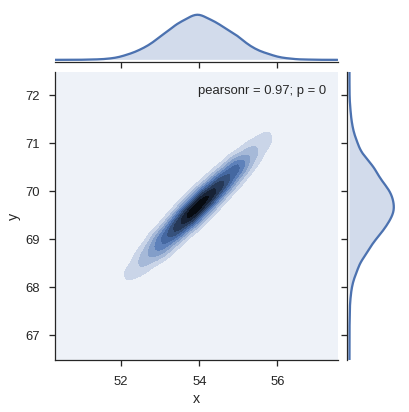

In [4]:
norm_df = pd.DataFrame(mnorm(mu, cov).rvs(10000), columns=['x', 'y'])
print(norm_df.mean())
print(norm_df.cov())
sns.jointplot(x='x', y='y', data=norm_df, kind='kde');

In [5]:
def f1(X, j, mu, cov):
    sigma_1 = cov[0, 0]**0.5
    sigma_2 = cov[1, 1]**0.5
    rho = cov[0, 1]/(sigma_1*sigma_2)
    loc = mu[0] + (sigma_1/sigma_2)*rho*(X[1] - mu[1])
    scale = (1 - rho**2)*sigma_1**2
    return sp_norm(loc=loc, scale=scale).rvs()


def f2(X, j, mu, cov):
    sigma_1 = cov[0, 0]**0.5
    sigma_2 = cov[1, 1]**0.5
    rho = cov[0, 1]/(sigma_1*sigma_2)
    loc = mu[1] + (sigma_2/sigma_1)*rho*(X[0] - mu[0])
    scale = (1 - rho**2)*sigma_2**2
    return sp_norm(loc=loc, scale=scale).rvs()


distributions = [partial(f1, mu=mu, cov=cov), partial(f2, mu=mu, cov=cov)]
iterations = 10000
samples = gibbs(np.zeros((1, 2)), iterations, distributions)
gibbs_df = pd.DataFrame(samples, columns=['x', 'y'])
print(gibbs_df.mean())
print(gibbs_df.cov())

x    53.860436
y    69.592923
dtype: float64
          x         y
x  5.905471  4.776264
y  4.776264  3.935290


1000
x    53.996843
y    69.704364
dtype: float64
          x         y
x  0.032130  0.025358
y  0.025358  0.020955


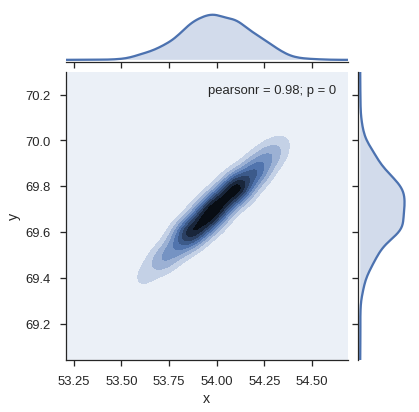

In [6]:
drop = 1000
thin = 9
thinned_df = gibbs_df.iloc[drop:iterations:thin]
print(len(thinned_df))
print(thinned_df.mean())
print(thinned_df.cov())
sns.jointplot(x='x', y='y', data=thinned_df, kind='kde');

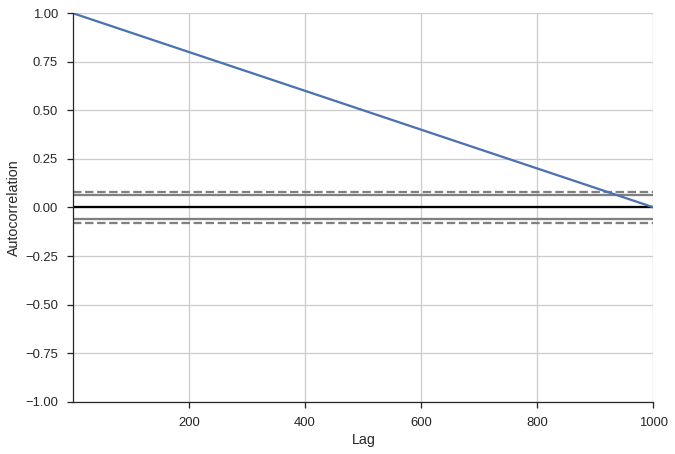

In [7]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(thinned_df)
sns.despine()

# Variable Selection

## Test

In [13]:
size = 1000
dims = 5
zero_coefs = np.random.rand(dims) < 0.5
coefs = np.random.rand(1, dims)
coefs[:, zero_coefs] = 0

X = np.random.rand(size, dims)
Y = ((X @ coefs.T) + np.random.randn(size, 1)*10)
print(Y.shape)
coefs

(1000, 1)


array([[ 0.29025402,  0.        ,  0.39693165,  0.93930174,  0.        ]])

In [14]:
β_lstsq, *_ = np.linalg.lstsq(X, Y)
print(β_lstsq.flatten(), (Y - X@β_lstsq).T@(Y - X@β_lstsq))

[-0.92327345  0.75567205  0.02974554  0.65171962  0.53658238] [[ 97864.67149887]]


In [16]:
β_zero = np.zeros(dims)
var_zero = 1000
p = np.array([0.5, 0.9, 0.1, 0.1, 0.5])
τ = np.ones_like(β_zero)
υ = -10 * np.ones_like(β_zero)
λ = 10 * np.ones_like(β_zero)
ν = 2
iterations = 10000
β, var, chain, probs = variable_selection(X, Y, β_zero, var_zero, p, τ, ν, υ, λ, iterations, verbose=10)

0th iteration
Error: 98268.20520914697
β: [ 0.34409113  0.         -0.18318596  0.04999733  0.        ]
σ²: 103.476648623306, σ: 10.172347252394896

1000th iteration
Error: 98073.24649938701
β: [ 0.          0.          0.35311113  0.26064597  0.        ]
σ²: 97.8953690259076, σ: 9.894208863062655

2000th iteration
Error: 98004.95349547507
β: [ 0.          0.          0.0406907   0.94435663  0.10728586]
σ²: 98.27804865606313, σ: 9.913528567370104

3000th iteration
Error: 98064.77718563762
β: [ 0.          0.         -0.45532134  1.22956675  0.        ]
σ²: 103.66773222992653, σ: 10.181735226862195

4000th iteration
Error: 98021.35866418235
β: [ 0.          0.30219733  0.54382342  0.15001035  0.        ]
σ²: 95.54659669177654, σ: 9.774793946256695

5000th iteration
Error: 98071.64121467501
β: [ 0.18596738  0.          0.          0.          1.02314317]
σ²: 101.2637571328203, σ: 10.062989472955852

6000th iteration
Error: 98132.90130049676
β: [ 0.05142809  0.          0.91805416 -0.1773

In [17]:
chain_df = pd.DataFrame(chain)
chain_df

,0,1,2,3,4,5
0,0.344091,0.0,-0.183186,0.049997,0.000000,103.476649
1,0.606664,0.0,-0.277219,0.329348,0.505381,95.044864
2,0.145251,0.0,0.000000,0.000000,0.727653,87.003487
3,0.000000,0.0,-0.022969,0.068021,0.920753,97.174042
4,0.000000,0.0,0.265368,-0.258640,0.649962,98.026932
...,...,...,...,...,...,...
9995,0.000000,0.0,0.018186,1.006489,0.000000,98.107368
9996,0.000000,0.0,0.000000,0.737716,0.000000,94.180135
9997,0.009098,0.0,-0.155005,1.296971,0.000000,102.166128
9998,-0.204892,0.0,0.053249,0.877554,0.000000,97.435785


In [22]:
(chain_df.iloc[:, :-1] == 0).mean()

0    0.6281
1    0.9377
2    0.1632
3    0.0870
4    0.6158
dtype: float64

## Test 2

(100, 1)


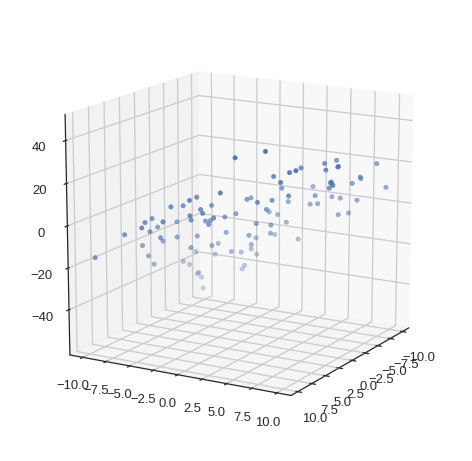

In [23]:
X = np.random.rand(100, 2) * 20 - 10
Y = X @ [[2], [3]] + np.random.randn(100, 1)*5

print(Y.shape)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*X.T, Y)
ax.view_init(15, 30)

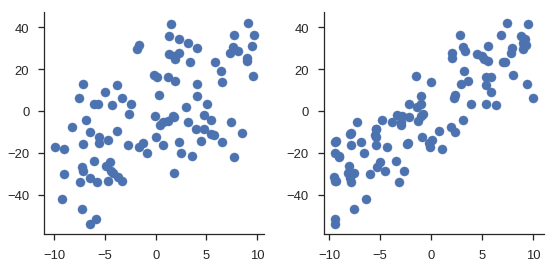

In [11]:
_, axes = plt.subplots(1, 2, figsize=(8, 4))
ax1, ax2 = axes
ax1.scatter(X[:, 0], Y)
ax2.scatter(X[:, 1], Y)
plt.tight_layout()
sns.despine()

In [ ]:
β_zero = np.array([0, 0])
var_zero = 10000
p = np.array([0.5, 0.5])
τ = np.ones_like(β_zero)
υ = -10 * np.ones_like(β_zero)
λ = 10 * np.ones_like(β_zero)
ν = 2
iterations = 1000
β, var, chain, probs = variable_selection(X, Y, β_zero, var_zero, p, τ, ν, υ, λ, iterations)